### сверточная нейронная сеть для классификации кошек и собак

In [ ]:
import torch
import torchvision

from torch.utils.data import Dataset, DataLoader, random_split

from torchvision.transforms import v2

import torch.nn as nn

from torch.optim import Adam, RMSprop

import os
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from PIL import Image

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
class Pictures(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.transform = transform

        self.len_dataset = 0
        self.data_list = []

        for path_dir, dir_list, file_list in os.walk(path):
            if path_dir == path:
                self.classes = dir_list
                self.class_to_idx = {
                    cls_name: i for i, cls_name in enumerate(self.classes)
                }
                continue
            cls = path_dir.split('\\')[-1]

            for name_file in file_list:
                file_path = os.path.join(path_dir, name_file)
                self.data_list.append((file_path, self.class_to_idx[cls]))

            self.len_dataset += len(file_list)

    def __len__(self):
        return self.len_dataset

    def __getitem__(self, index):
        file_path, target = self.data_list[index]
        sample = np.array(Image.open(file_path))

        if self.transform is not None:
            sample = self.transform(sample)
            
        return sample, target

In [4]:
transform = v2.Compose([
    v2.ToImage(),
    v2.Resize(size=(150, 150), antialias=True),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

In [5]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("d4rklucif3r/cat-and-dogs")

# print("Path to dataset files:", path) 

In [6]:
test = Pictures(r'C:\Users\mrmax\.cache\kagglehub\datasets\d4rklucif3r\cat-and-dogs\versions\1\dataset\test_set', transform=transform)
data = Pictures(r'C:\Users\mrmax\.cache\kagglehub\datasets\d4rklucif3r\cat-and-dogs\versions\1\dataset\training_set', transform=transform)
train, val = random_split(data, [0.7, 0.3], generator=torch.Generator().manual_seed(42))

In [7]:
train_loaded = DataLoader(dataset=train, batch_size=200, shuffle=True)
val_loaded = DataLoader(dataset=val, batch_size=200, shuffle=True)
test_loaded = DataLoader(dataset=test, batch_size=200, shuffle=True)

In [ ]:
def out(H_in, kernel_size, padding=0, dilation=1, stride=1): #функция для расчета размера свертки на выходе
    return int(H_in + 2 * padding - dilation * (kernel_size - 1) - 1 / stride) + 1
out(34, 7)

28

In [9]:
class NeuralNetwork(nn.Module):
    def __init__(self, input, output):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(input, 12, (3, 3)),                         #(batch_size, 1, 150, 150) => (batch_size, 12, 148, 148)
            nn.ReLU(),         
            nn.BatchNorm2d(12),                     
            nn.MaxPool2d(kernel_size=2, padding=0),               #(batch_size, 12, 148, 148) => (batch_size, 12, 74, 74)
            nn.Dropout2d(0.1),
            
            nn.Conv2d(12, 25, (7, 7)),                            #(batch_size, 12, 74, 74) => (batch_size, 25, 68, 68)
            nn.ReLU(),
            nn.BatchNorm2d(25),
            nn.MaxPool2d(kernel_size=2, padding=0),               #batch_size, 25, 68, 68) => (batch_size, 25, 34, 34)
            nn.Dropout2d(0.1),

            nn.Conv2d(25, 33, (7, 7)),                            #(batch_size, 25, 34, 34) => (batch_size, 33, 28, 28)
            nn.ReLU(),
            nn.BatchNorm2d(33),
            nn.MaxPool2d(kernel_size=2, padding=0),               #(batch_size, 33, 28, 28) => (batch_size, 33, 14, 14)
            nn.Dropout2d(0.1),
            
            # nn.Flatten(),                                       #(batch_size, 33*14*14)
            nn.AdaptiveAvgPool2d((3, 3))
        )                                      

        self.classifier = nn.Sequential(
            nn.Linear(33*3*3, 150),
            # nn.BatchNorm1d(300),
            nn.Dropout(0.6),
            nn.ReLU(),
            nn.Linear(150, 75),
            # nn.BatchNorm1d(150),
            nn.Dropout(0.7),
            nn.ReLU(),
            nn.Linear(75, 30),
            # nn.BatchNorm1d(30),
            nn.Dropout(0.6),
            nn.ReLU(),
            nn.Linear(30, output),
            nn.Dropout(0.4),
            nn.Sigmoid()
        )


    def forward(self, x):
        y = self.conv_layers(x)
        y = y.view(y.size(0), -1)
        y = self.classifier(y)
        return y

model = NeuralNetwork(3, 2).to(device)

In [ ]:

loss_func = nn.BCELoss().to(device)  #Binary cross-entropy для бинарной классификации
opt = Adam(model.parameters(), lr=1e-3)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.1)

In [11]:
class Train:
    def __init__(self, model, EPOCHS=5, name_for_save='model'):
        self.model = model
        self.mean_train_loss = []
        self.mean_train_acc = []
        self.mean_val_loss = []
        self.mean_val_acc = []
        

        threshold = 0.01

        maxAcc = -1
        for epoch in range(EPOCHS):
            self.model.train()

            accuracies = []
            losses = []
            train_loop = tqdm(train_loaded, leave=False)
            for i, data in enumerate(train_loop):
                x = data[0].to(torch.float32).to(device)
                targets = data[1]

                targets = targets.reshape(-1).to(torch.int32)
                targets = torch.eye(2)[targets].to(device)

                pred = self.model(x)
                loss = loss_func(pred, targets)
                acc = self.accuracy(pred, targets)

                accuracies.append(acc)
                losses.append(loss.item())

                if i % 100 == 0:
                    print(f'epoch {epoch}   iteration {i+epoch*len(train_loaded)}, train accuracy: {acc:.2f}, loss: {loss:.4f}')

                opt.zero_grad()
                loss.backward()
                opt.step()

            acc_mean = np.mean(np.array(accuracies))
            self.mean_train_acc.append(acc_mean)

            los_mean = np.mean(np.array(losses))
            self.mean_train_loss.append(los_mean)


            print()
            print('='*50)

            self.model.eval()

            accuracies = []
            losses = []
            for i, data in enumerate(val_loaded):
                x = data[0].to(torch.float32).to(device)
                targets = data[1]

                targets = targets.reshape(-1).to(torch.int32)
                targets = torch.eye(2)[targets].to(device)

                pred = self.model(x)
                loss = loss_func(pred, targets)

                accuracies.append(self.accuracy(pred, targets))
                losses.append(loss.item())

            acc_mean = np.mean(np.array(accuracies))
            self.mean_val_acc.append(acc_mean)

            los_mean = np.mean(np.array(losses))
            self.mean_val_loss.append(los_mean)
            print(f'epoch {epoch}')
            print(f'validation accuracy - {acc_mean:.2f}')
            print(f'validation loss\t- {los_mean:.4f}')
            
            if acc_mean - threshold > maxAcc and acc_mean >= 0.7:
                maxAcc = acc_mean
                torch.save(self.model.state_dict(), f'models/{name_for_save}_{epoch}_{maxAcc:.2f}.pth')
                print(f'model is saved because mean_accuracy = {acc_mean:.2f} and it\'s best')

            print('='*50)
            print()

            if epoch + 1 % 10 == 0:
                lr_scheduler.step()

    def get_model(self):
        return self.model

    def accuracy(self, output, labels):
        pred = torch.argmax(output, dim=1)
        corrects = (pred == labels.argmax(dim=1)).sum().item()
        return corrects / len(labels)
    
    def acc_plot_show(self):
        plt.plot(self.mean_train_acc)
        plt.plot(self.mean_val_acc)
        plt.legend(['acc_train', 'acc_val'])
        plt.show()

    def loss_plot_show(self):
        plt.plot(self.mean_train_loss)
        plt.plot(self.mean_val_loss)
        plt.legend(['loss_train', 'loss_val'])
        plt.show()



In [12]:
class Test:
    def __init__(self, model):
        self.model = model
        accuracies = []

        self.model.eval()
        with torch.no_grad():

            test_loop = tqdm(test_loaded, leave=False)
            for i, data in enumerate(test_loop):
                x = data[0].to(torch.float32).to(device)
                targets = data[1].reshape(-1).to(torch.int64).to(device)

                pred = self.model(x)

                accuracies.append(self.accuracy(pred, targets))


            acc_mean = np.mean(np.array(accuracies))
            print(f'test accuracy - {acc_mean:.2f}')

    def accuracy(self, output, labels):
        pred = torch.argmax(output, dim=1)
        corrects = (pred == labels).sum().item()
        return corrects / len(labels)

#### Обучим модель

In [13]:
conv_model = Train(model, EPOCHS=50)

  0%|          | 0/28 [00:00<?, ?it/s]

epoch 0   iteration 0, train accuracy: 0.48, loss: 0.7012



epoch 0
validation accuracy - 0.51
validation loss	- 0.6929



  4%|▎         | 1/28 [00:00<00:18,  1.43it/s]

epoch 1   iteration 28, train accuracy: 0.49, loss: 0.6960



epoch 1
validation accuracy - 0.58
validation loss	- 0.6913



  4%|▎         | 1/28 [00:00<00:23,  1.15it/s]

epoch 2   iteration 56, train accuracy: 0.47, loss: 0.6968



epoch 2
validation accuracy - 0.59
validation loss	- 0.6885



  4%|▎         | 1/28 [00:00<00:19,  1.41it/s]

epoch 3   iteration 84, train accuracy: 0.51, loss: 0.6929



epoch 3
validation accuracy - 0.62
validation loss	- 0.6774



  4%|▎         | 1/28 [00:00<00:24,  1.11it/s]

epoch 4   iteration 112, train accuracy: 0.52, loss: 0.6826



epoch 4
validation accuracy - 0.63
validation loss	- 0.6660



  4%|▎         | 1/28 [00:00<00:25,  1.05it/s]

epoch 5   iteration 140, train accuracy: 0.56, loss: 0.6894



epoch 5
validation accuracy - 0.66
validation loss	- 0.6530



  4%|▎         | 1/28 [00:00<00:19,  1.42it/s]

epoch 6   iteration 168, train accuracy: 0.56, loss: 0.6584



epoch 6
validation accuracy - 0.67
validation loss	- 0.6396



  4%|▎         | 1/28 [00:00<00:19,  1.40it/s]

epoch 7   iteration 196, train accuracy: 0.62, loss: 0.6661



epoch 7
validation accuracy - 0.69
validation loss	- 0.6286



  4%|▎         | 1/28 [00:00<00:19,  1.35it/s]

epoch 8   iteration 224, train accuracy: 0.61, loss: 0.6488



epoch 8
validation accuracy - 0.71
validation loss	- 0.6203
model is saved because mean_accuracy = 0.71 and it's best



  4%|▎         | 1/28 [00:00<00:11,  2.41it/s]

epoch 9   iteration 252, train accuracy: 0.61, loss: 0.6571



epoch 9
validation accuracy - 0.72
validation loss	- 0.5809
model is saved because mean_accuracy = 0.72 and it's best



  4%|▎         | 1/28 [00:00<00:17,  1.54it/s]

epoch 10   iteration 280, train accuracy: 0.65, loss: 0.6461



epoch 10
validation accuracy - 0.72
validation loss	- 0.5931



  4%|▎         | 1/28 [00:00<00:16,  1.63it/s]

epoch 11   iteration 308, train accuracy: 0.70, loss: 0.6284



epoch 11
validation accuracy - 0.73
validation loss	- 0.5655



  4%|▎         | 1/28 [00:00<00:19,  1.37it/s]

epoch 12   iteration 336, train accuracy: 0.73, loss: 0.5850



epoch 12
validation accuracy - 0.71
validation loss	- 0.5724



  4%|▎         | 1/28 [00:00<00:16,  1.60it/s]

epoch 13   iteration 364, train accuracy: 0.69, loss: 0.5986



epoch 13
validation accuracy - 0.75
validation loss	- 0.5437
model is saved because mean_accuracy = 0.75 and it's best



  4%|▎         | 1/28 [00:00<00:16,  1.66it/s]

epoch 14   iteration 392, train accuracy: 0.77, loss: 0.5573



epoch 14
validation accuracy - 0.76
validation loss	- 0.5295



  4%|▎         | 1/28 [00:00<00:18,  1.46it/s]

epoch 15   iteration 420, train accuracy: 0.67, loss: 0.6585



epoch 15
validation accuracy - 0.76
validation loss	- 0.5331



  4%|▎         | 1/28 [00:00<00:19,  1.39it/s]

epoch 16   iteration 448, train accuracy: 0.72, loss: 0.5940



epoch 16
validation accuracy - 0.77
validation loss	- 0.5142
model is saved because mean_accuracy = 0.77 and it's best



  4%|▎         | 1/28 [00:00<00:21,  1.28it/s]

epoch 17   iteration 476, train accuracy: 0.68, loss: 0.5910



epoch 17
validation accuracy - 0.78
validation loss	- 0.5132
model is saved because mean_accuracy = 0.78 and it's best



  4%|▎         | 1/28 [00:00<00:19,  1.39it/s]

epoch 18   iteration 504, train accuracy: 0.73, loss: 0.5491



epoch 18
validation accuracy - 0.77
validation loss	- 0.5177



  4%|▎         | 1/28 [00:00<00:19,  1.39it/s]

epoch 19   iteration 532, train accuracy: 0.69, loss: 0.6062



epoch 19
validation accuracy - 0.78
validation loss	- 0.4960



  4%|▎         | 1/28 [00:00<00:20,  1.35it/s]

epoch 20   iteration 560, train accuracy: 0.78, loss: 0.5450



epoch 20
validation accuracy - 0.78
validation loss	- 0.4864



  4%|▎         | 1/28 [00:00<00:22,  1.21it/s]

epoch 21   iteration 588, train accuracy: 0.72, loss: 0.5745



epoch 21
validation accuracy - 0.80
validation loss	- 0.4802
model is saved because mean_accuracy = 0.80 and it's best



  4%|▎         | 1/28 [00:00<00:19,  1.35it/s]

epoch 22   iteration 616, train accuracy: 0.80, loss: 0.5380



epoch 22
validation accuracy - 0.81
validation loss	- 0.4660



  4%|▎         | 1/28 [00:00<00:17,  1.50it/s]

epoch 23   iteration 644, train accuracy: 0.74, loss: 0.5425



epoch 23
validation accuracy - 0.80
validation loss	- 0.4654



  4%|▎         | 1/28 [00:00<00:19,  1.39it/s]

epoch 24   iteration 672, train accuracy: 0.74, loss: 0.5126



epoch 24
validation accuracy - 0.81
validation loss	- 0.4449



  4%|▎         | 1/28 [00:00<00:19,  1.39it/s]

epoch 25   iteration 700, train accuracy: 0.78, loss: 0.5284



epoch 25
validation accuracy - 0.79
validation loss	- 0.4456



  4%|▎         | 1/28 [00:00<00:18,  1.48it/s]

epoch 26   iteration 728, train accuracy: 0.76, loss: 0.5581



epoch 26
validation accuracy - 0.81
validation loss	- 0.4412
model is saved because mean_accuracy = 0.81 and it's best



  4%|▎         | 1/28 [00:00<00:24,  1.12it/s]

epoch 27   iteration 756, train accuracy: 0.76, loss: 0.4999



epoch 27
validation accuracy - 0.82
validation loss	- 0.4295



  4%|▎         | 1/28 [00:00<00:19,  1.39it/s]

epoch 28   iteration 784, train accuracy: 0.78, loss: 0.5032



epoch 28
validation accuracy - 0.82
validation loss	- 0.4297



  4%|▎         | 1/28 [00:00<00:19,  1.38it/s]

epoch 29   iteration 812, train accuracy: 0.79, loss: 0.5081



epoch 29
validation accuracy - 0.82
validation loss	- 0.4068
model is saved because mean_accuracy = 0.82 and it's best



  4%|▎         | 1/28 [00:00<00:22,  1.18it/s]

epoch 30   iteration 840, train accuracy: 0.79, loss: 0.4566



epoch 30
validation accuracy - 0.82
validation loss	- 0.4245



  4%|▎         | 1/28 [00:00<00:19,  1.41it/s]

epoch 31   iteration 868, train accuracy: 0.81, loss: 0.4764



epoch 31
validation accuracy - 0.82
validation loss	- 0.3934



  4%|▎         | 1/28 [00:00<00:19,  1.42it/s]

epoch 32   iteration 896, train accuracy: 0.79, loss: 0.4804



epoch 32
validation accuracy - 0.83
validation loss	- 0.3986



  4%|▎         | 1/28 [00:00<00:18,  1.42it/s]

epoch 33   iteration 924, train accuracy: 0.78, loss: 0.4605



epoch 33
validation accuracy - 0.83
validation loss	- 0.3815



  4%|▎         | 1/28 [00:00<00:19,  1.37it/s]

epoch 34   iteration 952, train accuracy: 0.79, loss: 0.5050



epoch 34
validation accuracy - 0.82
validation loss	- 0.3922



  4%|▎         | 1/28 [00:00<00:19,  1.39it/s]

epoch 35   iteration 980, train accuracy: 0.80, loss: 0.4967



epoch 35
validation accuracy - 0.82
validation loss	- 0.3958



  4%|▎         | 1/28 [00:00<00:19,  1.40it/s]

epoch 36   iteration 1008, train accuracy: 0.82, loss: 0.4837



epoch 36
validation accuracy - 0.83
validation loss	- 0.3769
model is saved because mean_accuracy = 0.83 and it's best



  4%|▎         | 1/28 [00:00<00:20,  1.34it/s]

epoch 37   iteration 1036, train accuracy: 0.79, loss: 0.4747



epoch 37
validation accuracy - 0.83
validation loss	- 0.3757



  4%|▎         | 1/28 [00:00<00:18,  1.48it/s]

epoch 38   iteration 1064, train accuracy: 0.82, loss: 0.4711



epoch 38
validation accuracy - 0.84
validation loss	- 0.3703



  4%|▎         | 1/28 [00:00<00:19,  1.37it/s]

epoch 39   iteration 1092, train accuracy: 0.88, loss: 0.4044



epoch 39
validation accuracy - 0.84
validation loss	- 0.3661



  4%|▎         | 1/28 [00:00<00:19,  1.35it/s]

epoch 40   iteration 1120, train accuracy: 0.82, loss: 0.4917



epoch 40
validation accuracy - 0.84
validation loss	- 0.3596



  4%|▎         | 1/28 [00:01<00:27,  1.00s/it]

epoch 41   iteration 1148, train accuracy: 0.86, loss: 0.4171



epoch 41
validation accuracy - 0.84
validation loss	- 0.3617



  4%|▎         | 1/28 [00:00<00:20,  1.31it/s]

epoch 42   iteration 1176, train accuracy: 0.85, loss: 0.3886



epoch 42
validation accuracy - 0.84
validation loss	- 0.3663



  4%|▎         | 1/28 [00:00<00:20,  1.33it/s]

epoch 43   iteration 1204, train accuracy: 0.81, loss: 0.4374



epoch 43
validation accuracy - 0.85
validation loss	- 0.3613
model is saved because mean_accuracy = 0.85 and it's best



  4%|▎         | 1/28 [00:00<00:23,  1.16it/s]

epoch 44   iteration 1232, train accuracy: 0.80, loss: 0.4519



epoch 44
validation accuracy - 0.84
validation loss	- 0.3580



  4%|▎         | 1/28 [00:00<00:18,  1.45it/s]

epoch 45   iteration 1260, train accuracy: 0.85, loss: 0.4069



epoch 45
validation accuracy - 0.85
validation loss	- 0.3558



  4%|▎         | 1/28 [00:00<00:25,  1.06it/s]

epoch 46   iteration 1288, train accuracy: 0.82, loss: 0.4162



epoch 46
validation accuracy - 0.84
validation loss	- 0.3587



  4%|▎         | 1/28 [00:00<00:23,  1.17it/s]

epoch 47   iteration 1316, train accuracy: 0.86, loss: 0.3801



epoch 47
validation accuracy - 0.85
validation loss	- 0.3475



  4%|▎         | 1/28 [00:00<00:19,  1.39it/s]

epoch 48   iteration 1344, train accuracy: 0.81, loss: 0.4957



epoch 48
validation accuracy - 0.85
validation loss	- 0.3472



  4%|▎         | 1/28 [00:00<00:19,  1.35it/s]

epoch 49   iteration 1372, train accuracy: 0.83, loss: 0.4559



epoch 49
validation accuracy - 0.85
validation loss	- 0.3490



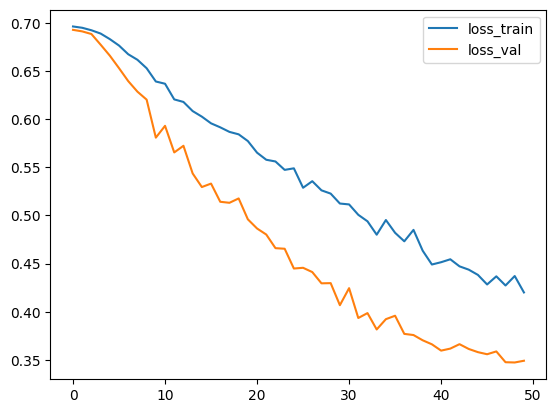

In [14]:
conv_model.loss_plot_show()

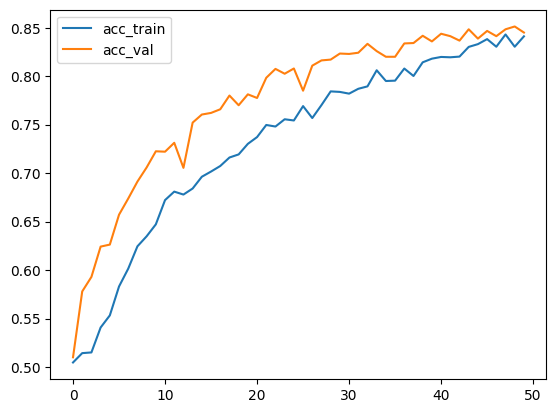

In [15]:
conv_model.acc_plot_show()

##### на графике видно, что точноть растет скачками вниз-вверх и точность на трейне и валидации стремится быть одинаковой

In [18]:
Test(conv_model.get_model())

test accuracy - 0.86


##### точность на тесте такая же как на валидации